# Combinging the latent space obatined from the 5000 input feature Vanilla Autoencoder architecutres of both Methylation and Gene Expression data

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from keras import backend as K #For explicitly \adjusting the learning rate


# 1. Early Integration of Final Bottleneck features

## 1.1. Load both datasets with 5000 most variable features

In [1]:
import joblib
meth_1000_chr_mvf_path = 'pancancer_meth_1000_chr_nonna_fillnamean.pkl'
ge_5000_mvf_path = 'ge_5000_mvf.pkl'
meth_1000_chr_mvf = joblib.load(meth_1000_chr_mvf_path)
ge_5000_mvf = joblib.load(ge_5000_mvf_path)
len(meth_1000_chr_mvf), ge_5000_mvf.shape

(23, (11093, 5000))

In [2]:
new_indices = []
for index in ge_5000_mvf.index:
    new_index = "-".join(index.split("-")[:4])
    new_indices.append(new_index)
# new_ge_5000_mvf = ge_5000_mvf.copy()
ge_5000_mvf.index = new_indices

# new_indices = []
# for index in meth_5000_mvf.index:
#     new_index = "-".join(index.split("-")[:4])
#     new_indices.append(new_index)
# # new_ge_5000_mvf = ge_5000_mvf.copy()
# meth_5000_mvf.index = new_indices


## 1.3. Combine features for each patient

In [26]:
# result = pd.concat([meth_5000_mvf, ge_5000_mvf], axis=1, join="inner")
pancan_df = pd.merge(meth_5000_mvf , ge_5000_mvf , left_index=True, right_index=True)
pancan_df.shape

(9151, 10030)

In [43]:
pancan_df.head()

,rs798149,rs5931272,rs5987737,rs1416770,rs2521373,rs6626309,rs5936512,cg27260772,cg01263942,cg13294849,...,ENSG00000259414.1,ENSG00000259404.4,ENSG00000227154.3,ENSG00000239856.3,ENSG00000255850.1,ENSG00000259195.1,ENSG00000211725.3,ENSG00000207708.1,ENSG00000258509.1,ENSG00000229992.1
TCGA-05-4384-01A,0.036316,0.031525,0.076172,0.073547,0.839844,0.882324,0.081299,0.758789,0.758789,0.661621,...,0.000000,0.633819,0.000000,0.0,0.536889,0.000000,0.591169,0.726956,0.0,0.000000
TCGA-05-4390-01A,0.037048,0.463867,0.940918,0.540039,0.075867,0.043671,0.942871,0.885742,0.132202,0.860352,...,0.000000,0.000000,0.565164,0.0,0.544821,0.000000,0.548618,0.735530,0.0,0.555917
TCGA-05-4396-01A,0.050934,0.053345,0.892090,0.087097,0.800781,0.122009,0.875488,0.896484,0.054718,0.849609,...,0.866652,0.656335,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
TCGA-05-4405-01A,0.937500,0.935059,0.587402,0.405273,0.889648,0.917480,0.073486,0.812500,0.709961,0.697266,...,0.000000,0.000000,0.000000,0.0,0.543711,0.561356,0.000000,0.000000,0.0,0.000000
TCGA-05-4410-01A,0.024994,0.023804,0.091614,0.889160,0.068420,0.108459,0.059143,0.746582,0.870117,0.680664,...,0.000000,0.000000,0.000000,0.0,0.557408,0.000000,0.560504,0.000000,0.0,0.000000


In [3]:
import pandas as pd
patient_metadata = pd.read_csv(r"C:\Users\ssrikrishnan6\ae_integration\info_all_ex.txt", sep = "\t")
patient_metadata = patient_metadata[[ 'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id','cases.0.project.project_id','cases.0.samples.0.sample_type']] #tolist()
patient_metadata.rename(columns={'cases.0.project.project_id': "cancer_type", "cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id":"tcga_id"},inplace=True)
patient_metadata.set_index("tcga_id", inplace=True)
patient_metadata

,cancer_type,cases.0.samples.0.sample_type
tcga_id,,
TCGA-NC-A5HI-01A-11R-A26W-07,TCGA-LUSC,Primary Tumor
TCGA-68-8251-01A-11R-2296-07,TCGA-LUSC,Primary Tumor
TCGA-98-A53A-01A-11R-A262-07,TCGA-LUSC,Primary Tumor
TCGA-39-5029-01A-01R-1443-07,TCGA-LUSC,Primary Tumor
TCGA-22-5474-01A-01R-1635-07,TCGA-LUSC,Primary Tumor
...,...,...
TCGA-YL-A9WL-01A-11R-A41O-07,TCGA-PRAD,Primary Tumor
TCGA-KK-A5A1-01A-11R-A29R-07,TCGA-PRAD,Primary Tumor
TCGA-HU-A4H6-01A-11R-A251-31,TCGA-STAD,Primary Tumor


## 1.3. Vanilla Autoencoder with these combined samples

In [27]:
X_train, X_val = train_test_split(pancan_df, test_size=0.2, random_state = seed(77))

In [34]:
ncol = pancan_df.shape[1] #Input Feature Number
encoding_dim = 100 #Nodes in Bottleneck layer

#Network configuration
input_dim = Input(shape = (ncol, ))

# Encoder Layers
encoded1 = Dense(1000, activation = 'relu')(input_dim)
encoded2 = Dense(500, activation = 'relu')(encoded1)
encoded3 = Dense(encoding_dim, activation = 'relu')(encoded2)

# Decoder Layers
decoded1 = Dense(500, activation = 'relu')(encoded3)
decoded2 = Dense(1000, activation = 'relu')(decoded1)
decoded3 = Dense(ncol, activation = 'sigmoid')(decoded2) #Applying sigmoid activation on the output layer ensure input also belongs to (0,1)

In [100]:
# Combine Encoder and Deocder layers
autoencoder = Model(inputs = input_dim, outputs = decoded3)

# Compile the Model
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error')#Should try Pseudo-Heuber Loss, Binary Crossentropy 
#adam - stochastic gradient descent algorithm
K.set_value(autoencoder.optimizer.learning_rate, 0.001) #Setting the learning rate to 10^-3

In [101]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10030)]           0         
                                                                 
 dense_12 (Dense)            (None, 1000)              10031000  
                                                                 
 dense_13 (Dense)            (None, 500)               500500    
                                                                 
 dense_14 (Dense)            (None, 100)               50100     
                                                                 
 dense_15 (Dense)            (None, 500)               50500     
                                                                 
 dense_16 (Dense)            (None, 1000)              501000    
                                                                 
 dense_17 (Dense)            (None, 10030)             1004

In [104]:
history = autoencoder.fit(X_train, X_train, epochs = 100, batch_size = 256, shuffle = False, verbose = 1, validation_data = (X_val, X_val))

Epoch 1/100
29/29 [==============================] - 2s 51ms/step - loss: 0.0446 - val_loss: 0.0575
Epoch 2/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0443 - val_loss: 0.0572
Epoch 3/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0442 - val_loss: 0.0573
Epoch 4/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0441 - val_loss: 0.0573
Epoch 5/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0440 - val_loss: 0.0573
Epoch 6/100
29/29 [==============================] - 1s 23ms/step - loss: 0.0440 - val_loss: 0.0573
Epoch 7/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0440 - val_loss: 0.0573
Epoch 8/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0439 - val_loss: 0.0573
Epoch 9/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0439 - val_loss: 0.0573
Epoch 10/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0439 - val_loss: 0.0574

dict_keys(['loss', 'val_loss'])


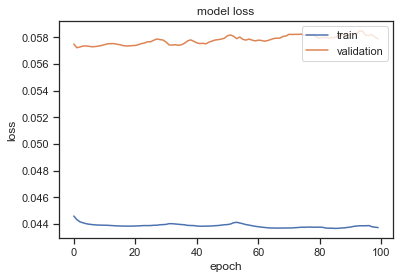

In [105]:
#Visualizing the Loss over epochs
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [39]:
#Obtain the reduced data
encoder = Model(inputs = input_dim, outputs = encoded3)
encoded_input = Input(shape = (encoding_dim, ))

encoded_train = pd.DataFrame(encoder.predict(pancan_df), index=pancan_df.index) #Maintain Index for Mapping to cancer type 
encoded_train = encoded_train.add_prefix('feature_')
encoded_train.shape

(9151, 100)

In [40]:
#output dataset
shape_before_removing_nan = encoded_train.shape
encoded_train.replace(0, np.nan, inplace=True) #Converting all the zero's to nan to use nan command

encoded_train.dropna(how='all',axis=1, inplace=True) #Removing columns with all nan rows
encoded_train.dropna(how='all',axis=0, inplace=True) #Removing rows with all nan columns

encoded_train.replace(np.nan, 0, inplace=True) #Converting all the nan's to zero to be compatible with t-SNE

encoded_train.to_csv("AE_Early_Meth_GE_Pancan.csv", index=True)
# encoded_train = pd.read_csv("Meth_AE_v0.csv",index_col=[0,1,2,3,4])

In [41]:
shape_before_removing_nan, encoded_train.shape

((9151, 100), (9151, 82))

In [42]:
# Perform t-SNE on AE encoded_features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=20, learning_rate=300, n_iter=400, verbose=1)
#TSNE(n_components=2, perplexity=105, n_iter=1000, verbose=1).fit_transform(encoded_train)
tsne_out = tsne.fit_transform(encoded_train)
tsne_components = pd.DataFrame(tsne_out, index = encoded_train.index ) #Maintain Index
tsne_components.head()

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 9151 samples in 0.001s...
[t-SNE] Computed neighbors for 9151 samples in 2.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9151
[t-SNE] Computed conditional probabilities for sample 2000 / 9151
[t-SNE] Computed conditional probabilities for sample 3000 / 9151
[t-SNE] Computed conditional probabilities for sample 4000 / 9151
[t-SNE] Computed conditional probabilities for sample 5000 / 9151
[t-SNE] Computed conditional probabilities for sample 6000 / 9151
[t-SNE] Computed conditional probabilities for sample 7000 / 9151
[t-SNE] Computed conditional probabilities for sample 8000 / 9151
[t-SNE] Computed conditional probabilities for sample 9000 / 9151
[t-SNE] Computed conditional probabilities for sample 9151 / 9151
[t-SNE] Mean sigma: 7.725754


C:\Users\ssrikrishnan6\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.686066
[t-SNE] KL divergence after 400 iterations: 2.140238


,0,1
TCGA-05-4384-01A,-1.830434,-3.518470
TCGA-05-4390-01A,-1.943863,-7.423149
TCGA-05-4396-01A,-1.293712,-8.204265
TCGA-05-4405-01A,-0.706349,1.338064
TCGA-05-4410-01A,0.142569,-1.684831


In [49]:
tsne_components.shape

(9151, 2)

In [44]:
import pandas as pd
patient_metadata = pd.read_csv(r"C:\Users\ssrikrishnan6\ae_integration\info_all_ex.txt", sep = "\t")
patient_metadata = patient_metadata[[ 'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id','cases.0.project.project_id','cases.0.samples.0.sample_type']] #tolist()
patient_metadata.rename(columns={'cases.0.project.project_id': "cancer_type", "cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id":"tcga_id"},inplace=True)
patient_metadata.set_index("tcga_id", inplace=True)

new_patient_indices = []
for index in patient_metadata.index:
    new_patient_indices.append("-".join(index.split("-")[:4]))
patient_metadata.index = new_patient_indices
patient_metadata.head()

,cancer_type,cases.0.samples.0.sample_type
TCGA-NC-A5HI-01A,TCGA-LUSC,Primary Tumor
TCGA-68-8251-01A,TCGA-LUSC,Primary Tumor
TCGA-98-A53A-01A,TCGA-LUSC,Primary Tumor
TCGA-39-5029-01A,TCGA-LUSC,Primary Tumor
TCGA-22-5474-01A,TCGA-LUSC,Primary Tumor


In [54]:
#Merging based on tcga_id
grouped_tsne = pd.merge(tsne_components , patient_metadata['cancer_type'] , how="inner", left_index=True, right_index=True)
grouped_tsne.to_csv("tsne_ge_meth_early_vanilla_ae.csv")
grouped_tsne.head()

,0,1,cancer_type
TCGA-05-4384-01A,-1.830434,-3.518470,TCGA-LUAD
TCGA-05-4390-01A,-1.943863,-7.423149,TCGA-LUAD
TCGA-05-4396-01A,-1.293712,-8.204265,TCGA-LUAD
TCGA-05-4405-01A,-0.706349,1.338064,TCGA-LUAD
TCGA-05-4410-01A,0.142569,-1.684831,TCGA-LUAD


In [55]:
grouped_tsne.shape

(9251, 3)

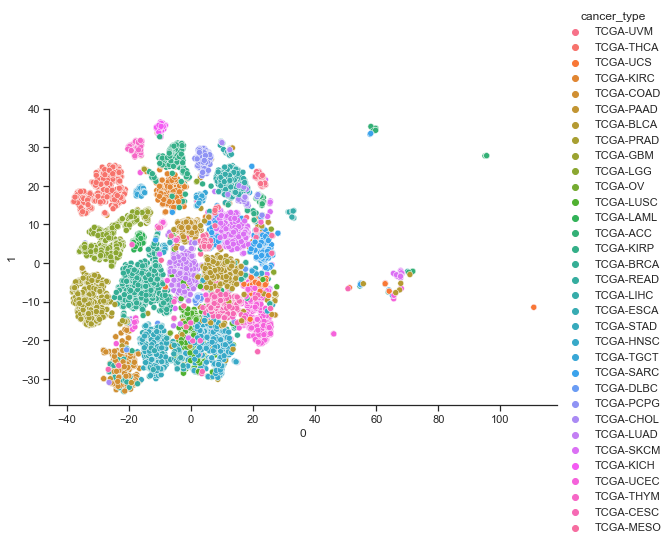

In [58]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')

cancer_types = grouped_tsne['cancer_type'].tolist()
cancer_types = list(set(cancer_types))

seaborn.relplot(data=grouped_tsne, x=0, y=1, hue='cancer_type', hue_order=cancer_types, aspect=1.61)
plt.show()

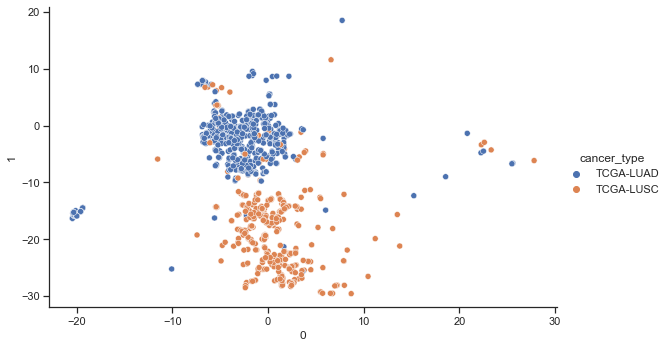

In [59]:
lung_cancer_types = ["TCGA-LUAD","TCGA-LUSC"] 
lung_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_cancer_types)]

seaborn.relplot(data=lung_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_cancer_types, aspect=1.61)
plt.show()

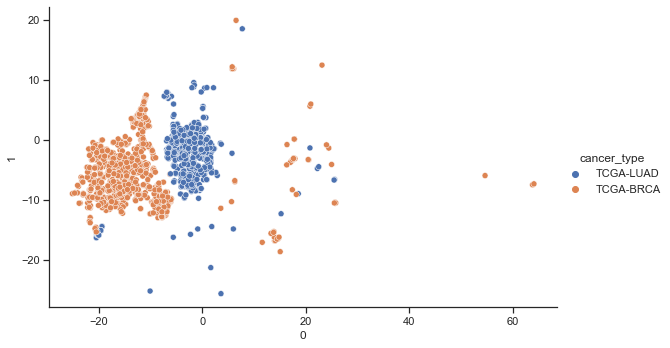

In [60]:
lung_breast_cancer_types = ["TCGA-LUAD","TCGA-BRCA"] 
lung_breast_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_breast_cancer_types)]

seaborn.relplot(data=lung_breast_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_breast_cancer_types, aspect=1.61)
plt.show()

# 2. Late Integration of Final Bottleneck features

In [4]:
import pandas as pd
meth_100_df_path = "Meth_AE_chr_100.csv"
ge_100_df_path = "GE_AE_Vanilla.csv"
ge_100_df = pd.read_csv(ge_100_df_path, index_col=0)
meth_100_df = pd.read_csv(meth_100_df_path, index_col=[0,1,2,3,4])

In [5]:
meth_100_df.head()

,,,,,feature_3,feature_5,feature_6,feature_7,feature_9,feature_10,feature_12,feature_13,feature_14,feature_16,...,feature_82,feature_83,feature_85,feature_86,feature_88,feature_90,feature_93,feature_95,feature_98,feature_99
patient,sample,sample_type,aliquot,file,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,5.541511,0.0,5.072050,0.0,2.666183,1.963223,0.0,0.163316,0.732340,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,4.148703,0.0,0.000000,0.006467
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,7.366412,0.0,3.835197,0.0,5.126200,2.377459,0.0,0.336157,3.125650,0.0,...,0.0,0.0,0.0,0.0,0.998013,0.0,2.577299,0.0,1.874216,0.000000
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,4.120066,0.0,2.073107,0.0,2.737824,0.959430,0.0,0.000000,2.024567,0.0,...,0.0,0.0,0.0,0.0,1.568415,0.0,8.160261,0.0,0.748063,0.000000
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,3.627484,0.0,1.425890,0.0,5.941448,2.042317,0.0,1.296161,2.161369,0.0,...,0.0,0.0,0.0,0.0,0.124631,0.0,0.992546,0.0,4.918741,0.000000
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,5.698373,0.0,3.470033,0.0,3.833233,0.148585,0.0,0.000000,1.968729,0.0,...,0.0,0.0,0.0,0.0,2.923609,0.0,3.191739,0.0,0.681116,0.000000


In [6]:
new_indices = []
for index in ge_100_df.index:
    new_index = "-".join(index.split("-")[:4])
    new_indices.append(new_index)
ge_100_df.index = new_indices

new_indices = []
for index in meth_100_df.index:
    new_index = index[1]
    new_indices.append(new_index)
meth_100_df.index = new_indices

In [7]:
meth_100_df.shape, ge_100_df.shape

((9756, 54), (11093, 92))

In [8]:
# result = pd.concat([meth_5000_mvf, ge_5000_mvf], axis=1, join="inner")
pancan_late_df = pd.merge(meth_100_df , ge_100_df , left_index=True, right_index=True)
pancan_late_df.shape

(9151, 146)

In [9]:
# Perform t-SNE on AE encoded_features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=50, learning_rate=300, n_iter=1000, verbose=1)
#TSNE(n_components=2, perplexity=105, n_iter=1000, verbose=1).fit_transform(encoded_train)
tsne_out_late = tsne.fit_transform(pancan_late_df)
tsne_components_late = pd.DataFrame(tsne_out_late, index = pancan_late_df.index ) #Maintain Index
tsne_components_late.head()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 9151 samples in 0.001s...
[t-SNE] Computed neighbors for 9151 samples in 2.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9151
[t-SNE] Computed conditional probabilities for sample 2000 / 9151
[t-SNE] Computed conditional probabilities for sample 3000 / 9151
[t-SNE] Computed conditional probabilities for sample 4000 / 9151
[t-SNE] Computed conditional probabilities for sample 5000 / 9151
[t-SNE] Computed conditional probabilities for sample 6000 / 9151
[t-SNE] Computed conditional probabilities for sample 7000 / 9151
[t-SNE] Computed conditional probabilities for sample 8000 / 9151
[t-SNE] Computed conditional probabilities for sample 9000 / 9151
[t-SNE] Computed conditional probabilities for sample 9151 / 9151
[t-SNE] Mean sigma: 6.276223


C:\Users\ssrikrishnan6\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.351372
[t-SNE] KL divergence after 1000 iterations: 1.194170


,0,1
TCGA-05-4384-01A,-43.041039,-4.726329
TCGA-05-4390-01A,-45.433422,-10.758327
TCGA-05-4396-01A,-42.695004,-11.020251
TCGA-05-4405-01A,-44.264400,-8.585375
TCGA-05-4410-01A,-44.172504,-10.367376


In [14]:
import pandas as pd
patient_metadata = pd.read_csv(r"C:\Users\ssrikrishnan6\ae_integration\info_all_ex.txt", sep = "\t")
patient_metadata = patient_metadata[[ 'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id','cases.0.project.project_id','cases.0.samples.0.sample_type']] #tolist()
patient_metadata.rename(columns={'cases.0.project.project_id': "cancer_type", "cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id":"tcga_id"},inplace=True)
patient_metadata.set_index("tcga_id", inplace=True)

new_patient_indices = []
for index in patient_metadata.index:
    new_patient_indices.append("-".join(index.split("-")[:-3]))
patient_metadata.index = new_patient_indices

In [15]:
patient_metadata

,cancer_type,cases.0.samples.0.sample_type
TCGA-NC-A5HI-01A,TCGA-LUSC,Primary Tumor
TCGA-68-8251-01A,TCGA-LUSC,Primary Tumor
TCGA-98-A53A-01A,TCGA-LUSC,Primary Tumor
TCGA-39-5029-01A,TCGA-LUSC,Primary Tumor
TCGA-22-5474-01A,TCGA-LUSC,Primary Tumor
...,...,...
TCGA-YL-A9WL-01A,TCGA-PRAD,Primary Tumor
TCGA-KK-A5A1-01A,TCGA-PRAD,Primary Tumor
TCGA-HU-A4H6-01A,TCGA-STAD,Primary Tumor
TCGA-BR-8291-01A,TCGA-STAD,Primary Tumor


In [16]:
#Merging based on tcga_id
grouped_tsne_late = pd.merge(tsne_components_late , patient_metadata['cancer_type'] , how="left", left_index=True, right_index=True)
grouped_tsne_late.to_csv("tsne_ge_meth_late_vanilla_ae.csv")
grouped_tsne_late

,0,1,cancer_type
TCGA-05-4384-01A,-43.041039,-4.726329,TCGA-LUAD
TCGA-05-4390-01A,-45.433422,-10.758327,TCGA-LUAD
TCGA-05-4396-01A,-42.695004,-11.020251,TCGA-LUAD
TCGA-05-4405-01A,-44.264400,-8.585375,TCGA-LUAD
TCGA-05-4410-01A,-44.172504,-10.367376,TCGA-LUAD
...,...,...,...
TCGA-ZS-A9CG-01A,17.891985,-69.343987,TCGA-LIHC
TCGA-ZT-A8OM-01A,18.076260,23.905893,TCGA-THYM
TCGA-ZU-A8S4-01A,13.282599,-19.121689,TCGA-CHOL
TCGA-ZU-A8S4-11A,24.112406,-67.323578,TCGA-CHOL


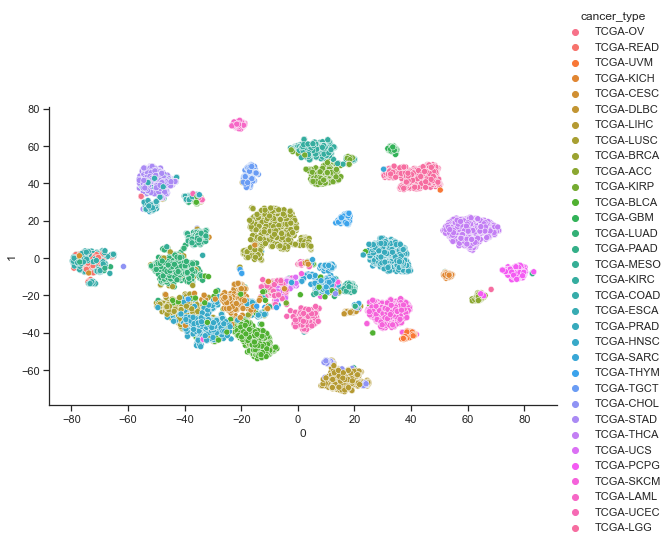

In [18]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')

cancer_types = grouped_tsne_late['cancer_type'].tolist()
cancer_types = list(set(cancer_types))

seaborn.relplot(data=grouped_tsne_late, x=0, y=1, hue='cancer_type', hue_order=cancer_types, aspect=1.61)
plt.show()

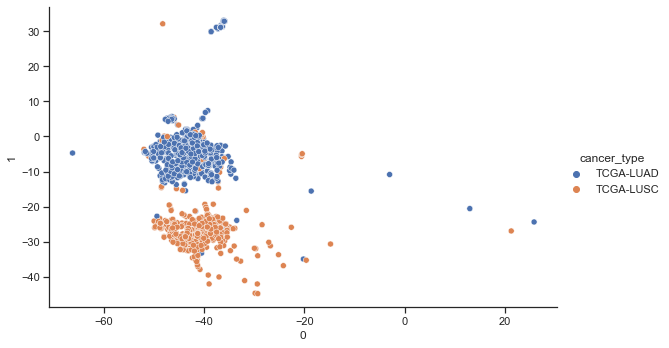

In [19]:
lung_cancer_types = ["TCGA-LUAD","TCGA-LUSC"] 
lung_cancer_df = grouped_tsne_late[grouped_tsne_late['cancer_type'].isin(lung_cancer_types)]

seaborn.relplot(data=lung_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_cancer_types, aspect=1.61)
plt.show()

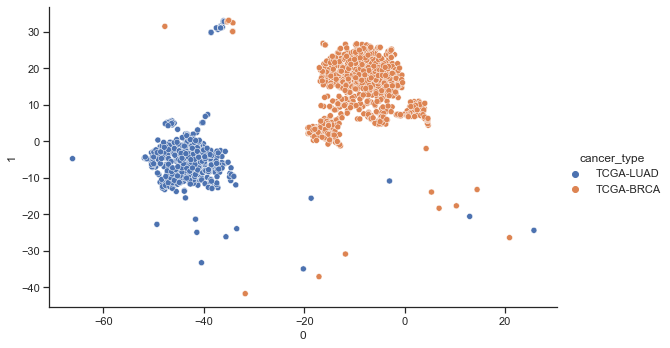

In [20]:
lung_breast_cancer_types = ["TCGA-LUAD","TCGA-BRCA"] 
lung_breast_cancer_df = grouped_tsne_late[grouped_tsne_late['cancer_type'].isin(lung_breast_cancer_types)]

seaborn.relplot(data=lung_breast_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_breast_cancer_types, aspect=1.61)
plt.show()